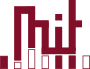 Department of Artificial Intelligence and Systems Engineering, ©2024, BME-MIT, Levente Alekszejenko, Dr. Gabor Hullam  
# **VIMIAC16 - Artificial Intelligence**
## 2024 Fall Semester
## **Lab 4 - Decision trees**

# **Decision Trees**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!wget https://share.mit.bme.hu/index.php/s/9ag8JsRD9mXWj85/download/dataset.csv

--2024-12-01 21:10:44--  https://share.mit.bme.hu/index.php/s/9ag8JsRD9mXWj85/download/dataset.csv
Resolving share.mit.bme.hu (share.mit.bme.hu)... 152.66.252.20
Connecting to share.mit.bme.hu (share.mit.bme.hu)|152.66.252.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5351430 (5.1M) [text/csv]
Saving to: ‘dataset.csv.1’

dataset.csv.1       100%[===================>]   5.10M  1.62MB/s    in 3.1s    

2024-12-01 21:10:48 (1.62 MB/s) - ‘dataset.csv.1’ saved [5351430/5351430]



## **1. Theoretical Background**

Decision trees are intuitive classifiers that are perhaps closest to human thinking. We can generally train them with relatively little data, and their structure is understandable to the human eye. Despite their simplicity, they can provide a decent predictive performance; thus, they are used in various fields ranging from medical decision support, through business life, to recommender systems.


![dtree](https://share.mit.bme.hu/index.php/apps/files_sharing/publicpreview/5GAKgGAAErwLr6n?file=/&fileId=3815291&x=1920&y=1080&a=true&etag=c084366203833f27c25fe8d16bbeb250)

### Overview

In classification problems, we can create a table from the data, like:

| Feature$_A$   | Feautre$_B$   | Label |
| :-----------: | :-----------: | :---: |
|      1        |      2        |   o   |
|      2        |      7        |   o   |
|     12        |      4        |   x   |
|     ...       |     ...       |  ...  |

In the above example, Feature$_A$ and Feature$_B$ represent some properties, and the Label is the outcome of a decision. For example, if $A = 2$ and $B = 7$, then the record will get class label `o`; and if $A = 12$ and $B = 4$, it gets class label `x`.

We can also draw this data in the $(A \times B)$ subspace:

![illustration](https://share.mit.bme.hu/index.php/apps/files_sharing/publicpreview/jJwKaRxqQS7WJy7?file=/&fileId=3815472&x=1920&y=1080&a=true&etag=53f8a992384228edc0a5f1c9920f6c77)

Two features are easy to illustrate in a plane, but if we get $n$ features, it requires an $n$-dimensional space. Unfortunately, it is hard to imagine, but after fixing a feature to a concrete value, we can generalize the illustration with $(n-1)$-dimensional hyperplanes.

## **1.1 Separation of samples**

Now, let us try to define a recursive algorithm that solves the classification problem by efficiently separating the feature space. This recursive algorithm shall divide the feature space to minimize the *unorderdness* of the class labels on both sides. To do so, we can divide the feature space by a straight line parallel to the axes:

![separations](https://share.mit.bme.hu/index.php/apps/files_sharing/publicpreview/fYDnEzPdzHXKNGD?file=/&fileId=3815457&x=1920&y=1080&a=true&etag=eb7584e97ad02851a9ae9daae8dca167)

By observing the figure, we can see that we did not gain much with the 1) separation: Only one red `o` remains on its left-hand side, but there are still many `o` and `x` labels randomly on the right.

Comparing the 2) and 3) separations, we can state that 2) is slightly better than the 3): There are 2 `x`'s on the left to the 2) line, and only one `o` remains on its right. Meanwhile, in the case of 3), there are 3 `o`'s below the separation line and 2 `x`'s above it.

To measure the quality of the separation, we shall evaluate the *unorderdness*, as it relates strongly to the correctness of the classification.

### **1.2 Entropy**

Coding or information theory defines (Shannon's) entropy $H$ to measure the *unorderdness*:

> $H = - \sum_{x \in X} p(x) \cdot \log_2 p(x)$,

where $X$ is the set of the label values.

When a set is completely ordered, i.e., contains elements with only one class label, it has an entropy of $H = 0$.

**Implement an entropy calculator function for a two class classification problem!** To solve this exercise, you can use the `np.log2()` function.

In [8]:
def get_entropy(n_label0: int, n_label1: int) -> float:
    tot = n_label0 + n_label1

    if tot == 0:
        return 0

    p1 = n_label0 / tot
    p2 = n_label1 / tot

    h = 0
    if p1 > 0:
        h -= p1 * np.log2(p1)
    if p2 > 0:
        h -= p2 * np.log2(p2)

    return h


#### *Check Your Solutions*:

If you have implemented the above function correctly, you will get the following results respectively:

`[0.0, 1.0, 0.8113]`

In [9]:
entropies = [get_entropy(12, 0), get_entropy(6, 6), get_entropy(3, 9)]
print(entropies)

[0.0, 1.0, 0.8112781244591328]


### **1.3 Information Gain and Structure Learning**

Let us specify a simple greedy training algorithm for decision trees.

$H(L)$ will denote the starting entropy and let us make a separation among feature $x$ at the $x \leq a$ value. Now, we can check the remaining entropies below this separation line $H(L | x \leq a)$, and above it $H(L | x > a)$.

By denoting $e = |\{L | x \leq a\}|$ the number of samples below the separation line and $f = |\{L | x > a\}|$ the number of samples above the separation line, it is natural that $|L| = e+f$.

From here, the efficiency of the separation is $H(L) - \Big(\frac{e}{|L|} \cdot H(L | x \leq a) + \frac{f}{|L|} \cdot H(L | x > a)\Big)$ which is the *information gain*. In human words, the utility of the separation is the weighted (by the number of samples) difference of the entropies of the resulting smaller sets and the starting entropy.

**Implement an information gain calculator function!** You can use the `get_entropy()` function that you have earlier created.

In [16]:
def get_information_gain(x: np.ndarray, y: np.ndarray, x_separation: float) -> float:
    e = len(y[x <= x_separation])  # Number of samples with x ≤ a
    f = len(y[x > x_separation])   # Number of samples with x > a
    total = len(y)                  # Total number of samples

    # Calculate the entropies for the two subsets
    H_L = get_entropy(np.sum(y == 0), np.sum(y == 1))  # Entropy of the full dataset
    H_L_x_leq_a = get_entropy(np.sum(y[x <= x_separation] == 0), np.sum(y[x <= x_separation] == 1))  # Entropy for x ≤ a
    H_L_x_gt_a = get_entropy(np.sum(y[x > x_separation] == 0), np.sum(y[x > x_separation] == 1))  # Entropy for x > a

    # Information gain is the difference in entropy before and after the split
    gain = H_L - (e / total) * H_L_x_leq_a - (f / total) * H_L_x_gt_a

    return gain

#### *Check Your Solutions:*

Check your solutions by running the code cells below. After running the second cell, you can use the slider that makes the latter cell recompute itself.

In [12]:
x_plot0 = np.random.normal(0, 4.5, 50)
x_plot1 = np.random.normal(10, 4.5, 50)
y_plot0 = np.random.normal(0, 3, 50)
y_plot1 = np.random.normal(0, 3, 50)

best_gain, best_gain_x = 0, 0

Actual gain: 0.2266
Best gain so far: 0.4275 @ x=4.5


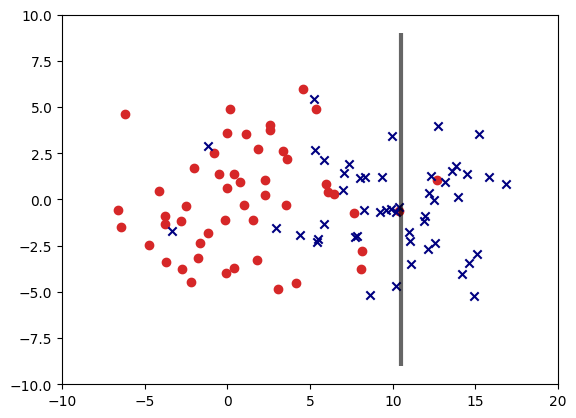

In [27]:
# @title A decision {run: "auto"}

slider = 10.5 # @param {type: "slider", min:-10, max: 20, step: 0.5}

#plotting:
plt.scatter(x_plot0, y_plot0, marker="o", color="tab:red")
plt.scatter(x_plot1, y_plot1, marker="x", color="navy")
plt.vlines(x = slider, ymin=-9, ymax=9, linewidth=3, alpha=0.6, color="k")
plt.xlim(-10, 20)
plt.ylim(-10, 10)

#computing information gain:
x = np.concatenate([x_plot0, x_plot1])
y = [0]*50+[1]*50
act_gain = get_information_gain(x, np.array(y), slider)
if act_gain>best_gain:
  best_gain = act_gain
  best_gain_x = slider

#printing gains:
print(f"Actual gain: {act_gain:.4f}\nBest gain so far: {best_gain:.4f} @ x={best_gain_x}")

From here, we can characterize the structure learning of a decision tree. Firstly, we shall systematically test all possible separations (e.g., among all values of all features) and look for one that maximizes the information gain. This optimal separating feature at the separation value will form a decision node in the tree. The resulting two subsets will correspond to two branches of this decision node. If one of these subsets is fully ordered (having an entropy of 0.0), it will be a leaf of the decision tree. Otherwise, we can iteratively continue on this yet-to-be-ordered subset and treat it as a child of the previously added decision node of the tree.

(Naturally, this algorithm is not optimal as it produces an overcomplicated tree; hence, it will lose its generalization ability. To this end, we can apply *pruning* on the decision tree to remove some brances, i.e. some of its nodes.)

## **2. Training a Decision Tree**

Rather than implementing an optimal decision tree training algorithm, we will use the `DecisionTreeClassifier` module provided by the `sklearn` package in Python.

In the following, we will use the dataset of a used car dealership. This dataset contains records of various cars. A customer somehow labeled those vehicles that he wanted to see. Our goal is now to learn his preferences and show him even more cars that might be appealing to him.

**As a first step, load and check the dataset!** The `decision` column contains the customer's labeling: if a record has a `decision = True` entry, the customer wants to see the corresponding vehicle. You can read the detailed description of the data set [here](https://share.mit.bme.hu/index.php/s/8rGnd3Bam9PqDzW).

In [28]:
cars_df = pd.read_csv('dataset.csv')
cars_df

,manufacturer,model,year_produced,odometer,engine_volume,price_huf,automatic_transmission,gasoline_engine,diesel_engine,gas_engine,electric_engine,fwd,rwd,awd,air_conditioner,cruise_control,abs,decision
0,Toyota,Yaris,2015,41500,1.3,2982000.0,False,True,False,False,False,True,False,False,True,False,True,True
1,Mercedes-Benz,Sprinter,1999,407500,2.9,2077000.0,False,False,True,False,False,False,True,False,False,False,False,False
2,Volkswagen,T5,2011,282000,2.0,4296000.0,False,False,True,False,False,True,False,False,True,False,False,False
3,Suzuki,Swift,2006,109000,1.3,1411000.0,False,True,False,False,False,True,False,False,True,False,False,False
4,Nissan,Note,2009,84000,1.4,1970000.0,False,True,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Dodge,Grand Caravan,2008,192000,3.8,3711000.0,True,True,False,False,False,True,False,False,True,False,False,False
49996,Kia,Rio,2014,95500,1.6,2517000.0,False,True,False,False,False,True,False,False,True,False,False,True
49997,BMW,730,1996,268500,3.0,1011000.0,True,True,False,False,False,False,True,False,True,False,False,False
49998,Kia,Sportage,2011,81000,2.0,4195000.0,False,True,False,False,False,True,False,False,True,False,False,False


### 2.1 Data Preparation

Unfortunately, the `sklearn` package's `DecisionTreeClassifier` implementation cannot process string inputs. Hence, we shall convert the values of the `manufacturer` and `model` columns to numbers. Now, we can use the `sklearn.preprocessing.OrdinalEncoder` [class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#ordinalencoder).

*Please note that this is not a general solution! This technique can be applied here, i.e. in the case of the current decision tree model, as it may only result in a more complex tree. But this conversion is avoidable in case of those models (e.g., neural networks) that build on the topology of the feature space.*

**Convert the categorical features into numbers!** Pay attention to the `OrdinalEncoder` as it expects a 2-dimensional input; however, the columns of a `pandas.DataFrame` object are 1-dimensional `Series` typed variables. For the conversion, you might use the following code:

```python
np.array(cars_df["manufacturer"].reshape(-1, 1))
```

In [37]:
from sklearn.preprocessing import OrdinalEncoder

oencoder_manufacturer = OrdinalEncoder()
oencoder_model = OrdinalEncoder()


# Convert the "manufacturer" column to numeric values
cars_df["manufacturer"] = oencoder_manufacturer.fit_transform(cars_df["manufacturer"].values.reshape(-1, 1))

# Convert the "model" column to numeric values
cars_df["model"] = oencoder_model.fit_transform(cars_df["model"].values.reshape(-1, 1))

**Create a train and test set by running the following cell!**

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cars_df.drop(columns=["decision"]),              #features
    cars_df["decision"],                             #labels
    test_size=0.2                                    #80% -> train, 20% -> test
)

### 2.2 Training

**Let us train a decision tree!** Firstly, we will create a tree with a depth of 1 and analyze its classification capabilities. In this laboratory exercise, we use the `entropy` criterion. Run the following cell to train the decision tree.

In [39]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=1, criterion="entropy")
dtree = dtree.fit(X_train, y_train)

**Let us check the resulting decision tree!**

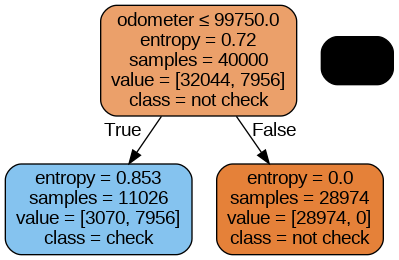

In [40]:
# Decision tree representation
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus


dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns, class_names=['not check','check'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### 2.3 Testing the Decision Tree

As you can see, both leaves of the decision tree contain misclassified elements (the entropy$\neq$ 0.0). **By running the following cell, run a prediction on the test data set.**

In [41]:
y_pred = dtree.predict(X_test)

We can use miscellaneous metrics to measure the classification performance. The `sklearn` package implements a variety of metrics; therefore, we will check some of these in the following cells.

In [42]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9218


This model achieves fairly high *accuracy*, but we are also sure (see the decision tree's visualization) that there are misclassified vehicles. **Let us see the level and types of classification error that the decision tree makes.**

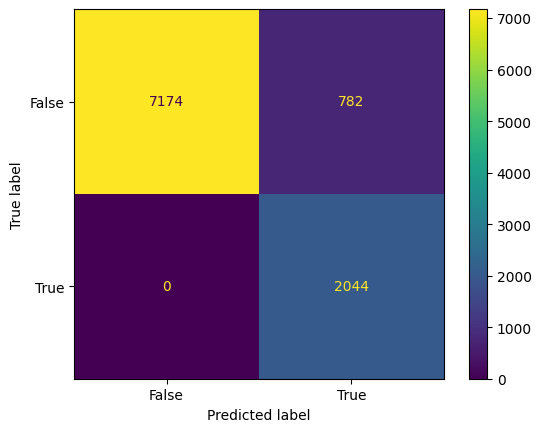

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 2.4 A Deeper Decision Tree

We can conclude that the decision based on a single node makes various mistakes. **Hence, we should implement a deeper decision tree, e.g., having a depth of 5.**

In [44]:
deeper_dtree = DecisionTreeClassifier(max_depth=5, criterion="entropy")
deeper_dtree = deeper_dtree.fit(X_train, y_train)

**Check the capabilities of the deeper decision tree!**

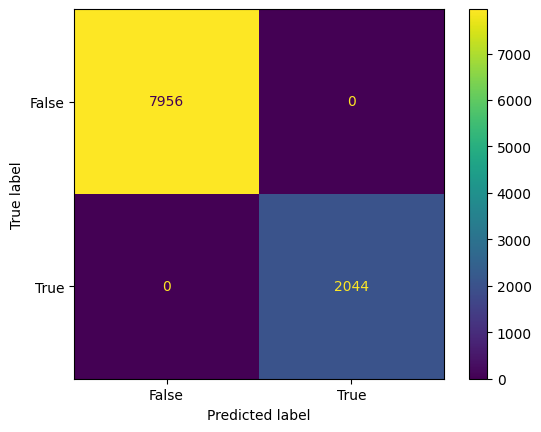

In [45]:
deeper_y_pred = deeper_dtree.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, deeper_y_pred)

Theoretically, this decision tree shall not make classification mistakes. The customer's original preference was to check such cars that:
- are cheaper than 3.5 million HUF,
- has an odometer value below 100.000 km,
- was manufactured after 2007.

**Check the rules identified by the decision tree!**

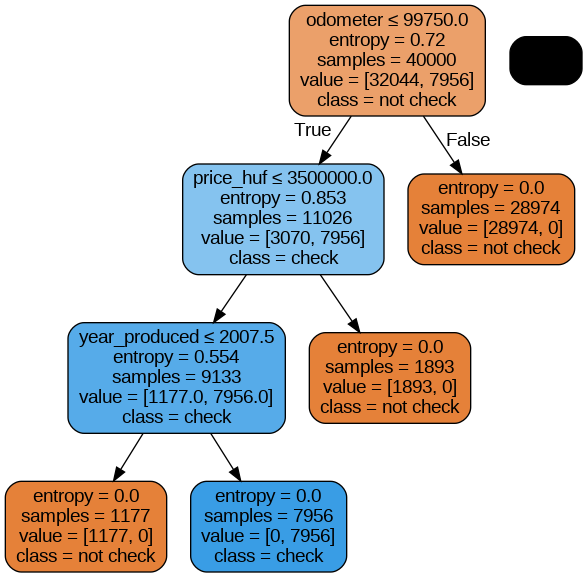

In [46]:
dot_data = StringIO()
export_graphviz(deeper_dtree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns, class_names=['not check','check'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

---
# **3. Submission**

Your task is to implement a classification system based on decision trees. You have to submit your solutions in the [Moodle system](edu.vik.bme.hu).

The implemented system has to process the `X_train` feature and `y_train` label inputs and make a prediction for the `X_test` input. The system shall return a `y_pred` output.

We recommend using `sklearn`'s [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#pipeline) structure to create a sophisticated solution. The `Pipeline` helps to combine data preparation, data preprocessing, classification, and prediction models (it is a generic AI software design pattern; hence, other models that implement the necessary methods, e.g., `tensorflow` or `pytorch` neural networks can also be part of a pipeline)

To facilitate the data processing of the `Pipelines`, the `sklearn` package provides a  [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class. By this class, we can specify data transformation steps for each column (e.g., an `OrdinalEncoder` in the current task for the textual features). For the unspecified, remaining features, we can also specify a behavior, for example, the `remainder = 'passthrough'` parameter passes through these columns without running any transformations on them.

In summary, the recommended (but not mandatory) `Pipeline` solution can be illustrated as:

![pipeline](https://share.mit.bme.hu/index.php/apps/files_sharing/publicpreview/67GGgTG9iLDr52b?file=/&fileId=3823392&x=1920&y=1080&a=true&etag=9211e19084e25e2a8263922a1ba18ca9)

**Attention!** It is possible that the `OrdinalEncoder` has not seen a specific feature value before the testing phase. In this case, it can substitute it with a default value. To achieve this, you can use the following code:

```python
OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
```

The code below is the skeleton of the `decision_tree_lab_solution.py` file that you have to complete and upload to the [Moodle system](edu.vik.bme.hu). (There is no need to import further packages to solve this assignment.)

In [49]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

def predict(X_train, y_train, X_test):
    ######################################################
    #Your code comes here:
    pipeline = DecisionTreeClassifier(max_depth=1, criterion="entropy")
    pipeline = dtree.fit(X_train, y_train)

    ######################################################
    return pipeline.predict(X_test)



def predict(X_train, y_train, X_test):
    categorical_cols = ['manufacturer', 'model']

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
            ('num', 'passthrough', X_train.columns.difference(categorical_cols))
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])


    pipeline.fit(X_train, y_train)

    return pipeline.predict(X_test)


**Submission link:**
https://edu.vik.bme.hu/mod/quiz/view.php?id=151795
